In [682]:
# Import packages
import os
import re  # regular expressions
import warnings
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

import rioxarray as rxr

from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint

from sklearn.datasets import dump_svmlight_file

warnings.simplefilter('ignore')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'BD', 'BA_DATA'))

In [683]:
thermal_path = os.path.join("ThermalData_8day", "MOD14A2.A2000049.h08v05.006.2015041131440.hdf")

In [684]:
vege_path = os.path.join("VegeData_16day", "MOD13A2.A2000049.h08v05.006.2015136104428.hdf")

In [685]:
tem_path = os.path.join("TemData", "MOD11A2.A2000049.h08v05.006.2015058135046.hdf")

In [686]:
with rio.open(thermal_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

<open DatasetReader name='ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [687]:
# Print all of the subdatasets in the data
with rio.open(thermal_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf:MODIS_Grid_8Day_Fire:FireMask
HDF4_EOS:EOS_GRID:ThermalData_8day\MOD14A2.A2000049.h08v05.006.2015041131440.hdf:MODIS_Grid_8Day_Fire:QA


In [688]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(thermal_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("FireMask", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
thermal_modis = np.stack(all_bands)
thermal_modis.shape

(1, 1200, 1200)

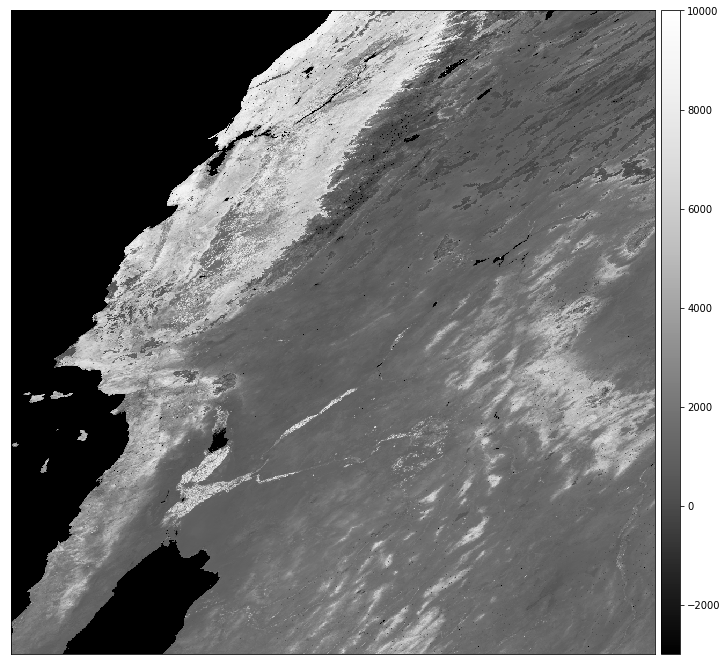

In [689]:
ep.plot_bands(vege_modis,
              scale=False)
plt.show()

In [690]:
with rio.open(vege_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

<open DatasetReader name='VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [691]:
# Print all of the subdatasets in the data
with rio.open(vege_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days NDVI
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days relative azimuth angle
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days composite day of the year
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days pixel reliability
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days EVI
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days VI Quality
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_Grid_16DAY_1km_VI:1 km 16 days red reflectance
HDF4_EOS:EOS_GRID:VegeData_16day\MOD13A2.A2000049.h08v05.006.2015136104428.hdf:MODIS_

In [692]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(vege_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("NDVI", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
vege_modis = np.stack(all_bands)
vege_modis.shape

(1, 1200, 1200)

In [693]:
with rio.open(tem_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

<open DatasetReader name='TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

In [694]:
# Print all of the subdatasets in the data
with rio.open(tem_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:LST_Day_1km
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:Emis_32
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:Clear_sky_days
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:Clear_sky_nights
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:QC_Day
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:Day_view_time
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:Day_view_angl
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:LST_Night_1km
HDF4_EOS:EOS_GRID:TemData\MOD11A2.A2000049.h08v05.006.2015058135046.hdf:MODIS_Grid_8Day_1km_LST:QC_Night
HDF4_EOS:EOS_GRID:TemData\

In [695]:
# Create empty list to append arrays (of band data)
all_bands = []

# Open the pre-fire HDF4 file
with rio.open(tem_path) as dataset:
    
    # Loop through each subdataset in HDF4 file
    for name in dataset.subdatasets:
        
        # Use regular expression to identify if subdataset has b0 in the name (the bands)
        if re.search("LST_Day", name):
            
            # Open the band subdataset
            with rio.open(name) as subdataset:
                modis_meta = subdataset.profile
                
                # Read band data as a 2 dim arr and append to list
                all_bands.append(subdataset.read(1))

# Stack pre-fire reflectance bands
tem_modis = np.stack(all_bands)
tem_modis.shape

(1, 1200, 1200)

In [696]:
glr_input = np.stack((thermal_modis[0], vege_modis[0], tem_modis[0]), axis=2)

In [697]:
glr_input.shape

(1200, 1200, 3)

In [698]:
glr_input

array([[[    4, -3000,     0],
        [    4, -3000,     0],
        [    4, -3000,     0],
        ...,
        [    5,  1969,     0],
        [    5,  2178,     0],
        [    5,  1746,     0]],

       [[    4, -3000,     0],
        [    4, -3000,     0],
        [    4, -3000,     0],
        ...,
        [    5,  1891,     0],
        [    5,  1647,     0],
        [    5,  1484,     0]],

       [[    4, -3000,     0],
        [    4, -3000,     0],
        [    4, -3000,     0],
        ...,
        [    5,  1609, 13888],
        [    5,  1555, 13888],
        [    5,  1629, 13959]],

       ...,

       [[    5,  1786, 14750],
        [    5,  1623, 14742],
        [    5,  1794, 14742],
        ...,
        [    5,  1756, 15353],
        [    5,  1865, 15342],
        [    5,  2002, 15332]],

       [[    5,  1803, 14742],
        [    5,  1910, 14752],
        [    5,  1885, 14774],
        ...,
        [    5,  1894, 15353],
        [    5,  1949, 15333],
        [    5,

In [699]:
glr_input[0][0]

array([    4, -3000,     0], dtype=int32)

In [700]:
# change from 3-d array to 2-d array
two_d_input = glr_input.reshape(1440000, 3)

In [701]:
two_d_input.shape

(1440000, 3)

In [702]:
two_d_input

array([[    4, -3000,     0],
       [    4, -3000,     0],
       [    4, -3000,     0],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [703]:
# filter out rows with fill value -3000 for vegetation indices 
a = two_d_input[two_d_input[:,1] != -3000]

In [704]:
a.shape

(1127952, 3)

In [705]:
a

array([[    4,  8048,     0],
       [    4,  8712,     0],
       [    4,  8845,     0],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [706]:
# filter out rows with fill value 0 for surface temperature
b = a[a[:,2] != 0] 

In [707]:
b.shape

(763545, 3)

In [708]:
b

array([[    5,  5947, 13441],
       [    5,  7168, 13441],
       [    4,  5231, 13306],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [709]:
#filter out rows with value not equal to 5, 7, 8 or 9 for FireMask
c = b[b[:,0] >= 5]
d = c[c[:,0] != 6]

In [710]:
c.shape

(688724, 3)

In [711]:
c

array([[    5,  5947, 13441],
       [    5,  7168, 13441],
       [    5,  3798, 13607],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [712]:
d.shape

(688724, 3)

In [713]:
d

array([[    5,  5947, 13441],
       [    5,  7168, 13441],
       [    5,  3798, 13607],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [714]:
# combining all the filters
d1 = two_d_input[two_d_input[:,1] != -3000]
d2 = d1[d1[:,2] != 0] 
d3 = d2[d2[:,0] >= 5]
d4 = d3[d3[:,0] != 6]

In [715]:
d4.shape

(688724, 3)

In [716]:
d4

array([[    5,  5947, 13441],
       [    5,  7168, 13441],
       [    5,  3798, 13607],
       ...,
       [    5,  1953, 15321],
       [    5,  2001, 15288],
       [    5,  1964, 15282]], dtype=int32)

In [717]:
# set FireMask == 7,8,9 (has fire) to 1, set FireMask == 5 (no fire) to 0
d4[:,0][d4[:,0] >= 7] = 1
d4[:,0][d4[:,0] == 5] = 0

In [718]:
d4.shape

(688724, 3)

In [719]:
d4

array([[    0,  5947, 13441],
       [    0,  7168, 13441],
       [    0,  3798, 13607],
       ...,
       [    0,  1953, 15321],
       [    0,  2001, 15288],
       [    0,  1964, 15282]], dtype=int32)

In [720]:
# check if there is fire
max(d4[:,0])

1

In [721]:
# convert surface temperature to Kelvin temperature
d4[:,2] = d4[:,2] * 0.02

In [722]:
d4.shape

(688724, 3)

In [723]:
d4

array([[   0, 5947,  268],
       [   0, 7168,  268],
       [   0, 3798,  272],
       ...,
       [   0, 1953,  306],
       [   0, 2001,  305],
       [   0, 1964,  305]], dtype=int32)

In [724]:
out = np.hsplit(d4, np.array([1, 3]))
y = out[0]
X = out[1]

In [725]:
X.shape

(688724, 2)

In [726]:
X

array([[5947,  268],
       [7168,  268],
       [3798,  272],
       ...,
       [1953,  306],
       [2001,  305],
       [1964,  305]], dtype=int32)

In [727]:
y.shape

(688724, 1)

In [728]:
# need to be generalized later for the whole dataset !
yy = y.flatten()

In [729]:
yy.ndim

1

In [ ]:
sklearn.datasets.dump_svmlight_file(X,yy,os.path.join("small_sample"),zero_based=False)